In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Using TensorFlow backend.


In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=LTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-11-05,53.64,54.85,52.86,54.23,200178.13,10714569.49
2018-11-06,56.03,56.18,53.62,53.64,248696.50,13567893.94
2018-11-07,54.06,56.53,53.40,56.03,224720.64,12371141.17
2018-11-08,52.28,54.67,52.14,54.06,165256.47,8795110.12
2018-11-09,51.89,52.65,51.31,52.28,131155.39,6816154.86


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [5]:
train, test = train_test_split(hist, test_size=0.2)

In [6]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


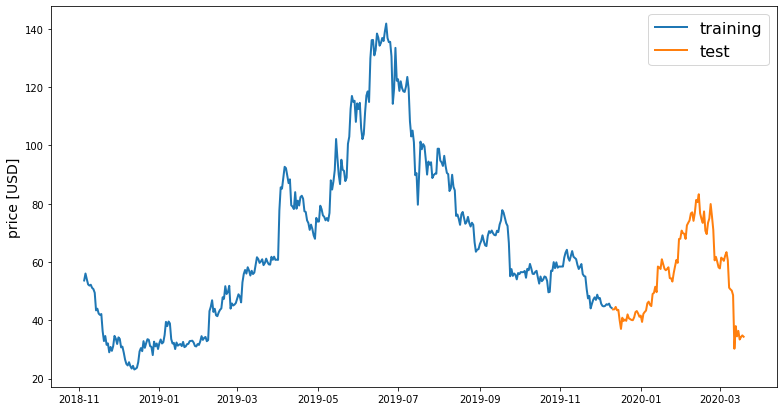

In [7]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [8]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [9]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [10]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [11]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [12]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 400
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [13]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [14]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/400
396/396 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 2/400
396/396 [==============================] - 0s 152us/step - loss: 0.0083
Epoch 3/400
396/396 [==============================] - 0s 156us/step - loss: 0.0062
Epoch 4/400
396/396 [==============================] - 0s 144us/step - loss: 0.0063
Epoch 5/400
396/396 [==============================] - 0s 152us/step - loss: 0.0058
Epoch 6/400
396/396 [==============================] - 0s 149us/step - loss: 0.0056
Epoch 7/400
396/396 [==============================] - 0s 146us/step - loss: 0.0054
Epoch 8/400
396/396 [==============================] - 0s 147us/step - loss: 0.0053
Epoch 9/400
396/396 [==============================] - 0s 145us/step - loss: 0.0050
Epoch 10/400
396/396 [==============================] - 0s 144us/step - loss: 0.0058
Epoch 11/400
396/396 [==============================] - 0s 156us/step - loss: 0.0050
Epoch 12/400
396/396 [==============================] - 0s 152us/step - loss

396/396 [==============================] - 0s 145us/step - loss: 0.0028
Epoch 98/400
396/396 [==============================] - 0s 137us/step - loss: 0.0028
Epoch 99/400
396/396 [==============================] - 0s 136us/step - loss: 0.0028
Epoch 100/400
396/396 [==============================] - 0s 136us/step - loss: 0.0029
Epoch 101/400
396/396 [==============================] - 0s 132us/step - loss: 0.0027
Epoch 102/400
396/396 [==============================] - 0s 133us/step - loss: 0.0027
Epoch 103/400
396/396 [==============================] - 0s 134us/step - loss: 0.0027
Epoch 104/400
396/396 [==============================] - 0s 135us/step - loss: 0.0028
Epoch 105/400
396/396 [==============================] - 0s 130us/step - loss: 0.0029
Epoch 106/400
396/396 [==============================] - 0s 132us/step - loss: 0.0028
Epoch 107/400
396/396 [==============================] - 0s 132us/step - loss: 0.0027
Epoch 108/400
396/396 [==============================] - 0s 129us/step

396/396 [==============================] - 0s 140us/step - loss: 0.0026
Epoch 193/400
396/396 [==============================] - 0s 141us/step - loss: 0.0026
Epoch 194/400
396/396 [==============================] - 0s 134us/step - loss: 0.0026
Epoch 195/400
396/396 [==============================] - 0s 135us/step - loss: 0.0027
Epoch 196/400
396/396 [==============================] - 0s 133us/step - loss: 0.0027
Epoch 197/400
396/396 [==============================] - 0s 131us/step - loss: 0.0026
Epoch 198/400
396/396 [==============================] - 0s 128us/step - loss: 0.0025
Epoch 199/400
396/396 [==============================] - 0s 126us/step - loss: 0.0026
Epoch 200/400
396/396 [==============================] - 0s 131us/step - loss: 0.0026
Epoch 201/400
396/396 [==============================] - 0s 130us/step - loss: 0.0026
Epoch 202/400
396/396 [==============================] - 0s 138us/step - loss: 0.0025
Epoch 203/400
396/396 [==============================] - 0s 139us/st

396/396 [==============================] - 0s 130us/step - loss: 0.0025
Epoch 288/400
396/396 [==============================] - 0s 133us/step - loss: 0.0024
Epoch 289/400
396/396 [==============================] - 0s 128us/step - loss: 0.0025
Epoch 290/400
396/396 [==============================] - 0s 137us/step - loss: 0.0024
Epoch 291/400
396/396 [==============================] - 0s 132us/step - loss: 0.0025
Epoch 292/400
396/396 [==============================] - 0s 136us/step - loss: 0.0024
Epoch 293/400
396/396 [==============================] - 0s 132us/step - loss: 0.0024
Epoch 294/400
396/396 [==============================] - 0s 138us/step - loss: 0.0025
Epoch 295/400
396/396 [==============================] - 0s 136us/step - loss: 0.0024
Epoch 296/400
396/396 [==============================] - 0s 130us/step - loss: 0.0024
Epoch 297/400
396/396 [==============================] - 0s 135us/step - loss: 0.0025
Epoch 298/400
396/396 [==============================] - 0s 142us/st

396/396 [==============================] - 0s 140us/step - loss: 0.0024
Epoch 383/400
396/396 [==============================] - 0s 136us/step - loss: 0.0024
Epoch 384/400
396/396 [==============================] - 0s 138us/step - loss: 0.0023
Epoch 385/400
396/396 [==============================] - 0s 131us/step - loss: 0.0023
Epoch 386/400
396/396 [==============================] - 0s 130us/step - loss: 0.0024
Epoch 387/400
396/396 [==============================] - 0s 132us/step - loss: 0.0023
Epoch 388/400
396/396 [==============================] - 0s 137us/step - loss: 0.0024
Epoch 389/400
396/396 [==============================] - 0s 132us/step - loss: 0.0024
Epoch 390/400
396/396 [==============================] - 0s 134us/step - loss: 0.0023
Epoch 391/400
396/396 [==============================] - 0s 134us/step - loss: 0.0023
Epoch 392/400
396/396 [==============================] - 0s 129us/step - loss: 0.0024
Epoch 393/400
396/396 [==============================] - 0s 138us/st

In [15]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.04603748327114824

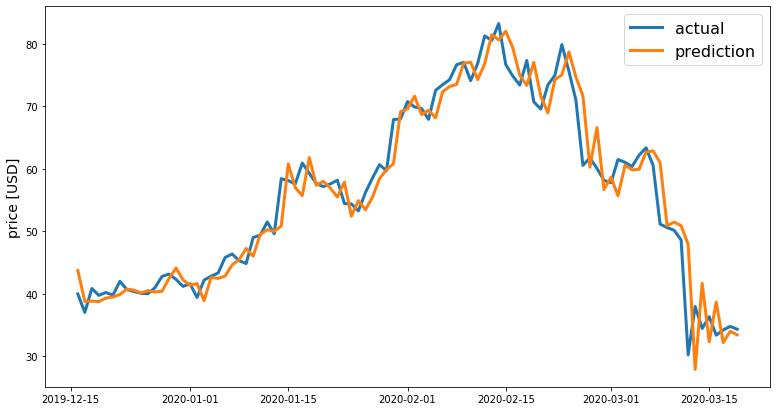

In [16]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)